In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Модель CatBoost

In [5]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import catboost as cb

from sklearn.model_selection import train_test_split

from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import shap

import os
import src

from dotenv import load_dotenv

In [7]:
pd.options.display.float_format = '{:,.2f}'.format

## Подготовка данных

In [8]:
load_dotenv(override=True)

WORK_DIR = os.getenv("DATA_DIR")
FILE_NAME = 'df_work_test.zip'

In [9]:
filepath = f'..\\{WORK_DIR}\\{FILE_NAME}'

df1 = pd.read_csv(filepath, index_col=0, parse_dates=True)

In [10]:
df1.shape

(47552, 50)

In [11]:
df1.head()

,QQ_C1,QQ_C2,QQ_C3,QQ_C4,QQ_C5,O2_tot,QQ_tot,O2_C1,O2_C2,O2_C3,...,BettaS_O2_5,QQ_tot_sl,BettaS_QW_1,BettaS_QW_2,BettaS_QW_3,BettaS_QW_4,BettaS_QW_5,lag_1,lag_2,lag_3
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2019-09-19 07:00:00,19.86,31.60,13.42,1.11,0.35,"5,150.46",66.34,"1,940.39","1,900.30",900.17,...,0.03,81.87,0.43,0.39,0.16,0.01,0.00,0.80,0.65,0.74
2019-09-19 11:00:00,19.47,30.74,13.03,2.44,0.59,"5,333.49",66.26,"1,872.99","1,874.70","1,065.91",...,0.03,81.34,0.42,0.38,0.16,0.03,0.01,0.84,0.80,0.65
2019-09-19 12:00:00,19.84,32.63,14.76,1.50,0.49,"5,597.81",69.22,"1,959.94","1,960.42","1,119.46",...,0.03,84.94,0.42,0.38,0.17,0.02,0.01,0.66,0.84,0.80
2019-09-19 13:00:00,19.38,33.45,17.46,4.09,0.65,"5,668.19",75.02,"1,984.12","1,984.66","1,133.48",...,0.03,91.66,0.39,0.36,0.19,0.04,0.01,1.11,0.66,0.84
2019-09-19 14:00:00,19.47,33.88,18.62,4.76,0.84,"5,710.83",77.57,"1,999.00","1,998.91","1,141.97",...,0.03,94.49,0.39,0.36,0.20,0.05,0.01,0.99,1.11,0.66


In [ ]:
# def add_lags_inplace(df: pd.DataFrame, num_lags: int, for_ac: bool = True) -> None:
#
#     if for_ac:
#         for lag in range(1, num_lags + 1):
#             lag_name = f'lag_{lag}'
#             df[lag_name] = df1.groupby('ac')['Fe2+'].shift(lag)
#     else:
#         for lag in range(1, num_lags + 1):
#             lag_name = f'lag_{lag}'
#             df[lag_name] = df['Fe2+'].shift(lag)
#
#     df.dropna(axis=0, inplace=True)

In [ ]:
# add_lags_inplace(df1, 3)

In [ ]:
# df1.shape

Проверим еще раз есть ли у нас пустые значения

In [12]:
null_check = df1.isna().sum()
null_check[null_check > 0]

Series([], dtype: int64)

Разделим данные на X и y, а также разделим на тестовую и тренировочную выборки. Для тренировки будем использовать 80 % всех данных, оставшиеся 20 % для теста. Так как мы считаем что у нас нет зависимости данных от времени, то есть мы ее выразили в виде лагов, то перемешаем данные перед разделением.

In [13]:
X = df1.drop(['Fe2+', 'ac'], axis=1)
X.reset_index(drop=True)
y = df1['Fe2+']
y.reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

## Обучим базовую модель

In [14]:
train_data = cb.Pool(X_train, y_train)
test_data = cb.Pool(X_test, y_test)

model_1 = cb.CatBoostRegressor(loss_function='RMSE',
                               train_dir='..\\cache',
                               n_estimators=1000,
                               depth=10,
                               l2_leaf_reg=1)

model_1.fit(train_data, plot=False, verbose=True, eval_set=test_data)

0:	learn: 0.8018497	test: 0.8298060	best: 0.8298060 (0)	total: 291ms	remaining: 4m 51s
1:	learn: 0.7915166	test: 0.8219800	best: 0.8219800 (1)	total: 402ms	remaining: 3m 20s
2:	learn: 0.7811373	test: 0.8137711	best: 0.8137711 (2)	total: 533ms	remaining: 2m 57s
3:	learn: 0.7713493	test: 0.8051077	best: 0.8051077 (3)	total: 700ms	remaining: 2m 54s
4:	learn: 0.7616967	test: 0.7977823	best: 0.7977823 (4)	total: 979ms	remaining: 3m 14s
5:	learn: 0.7523061	test: 0.7910237	best: 0.7910237 (5)	total: 1.27s	remaining: 3m 30s
6:	learn: 0.7428297	test: 0.7834748	best: 0.7834748 (6)	total: 1.58s	remaining: 3m 43s
7:	learn: 0.7339619	test: 0.7768149	best: 0.7768149 (7)	total: 1.82s	remaining: 3m 46s
8:	learn: 0.7250483	test: 0.7700697	best: 0.7700697 (8)	total: 2.04s	remaining: 3m 44s
9:	learn: 0.7171445	test: 0.7625902	best: 0.7625902 (9)	total: 2.25s	remaining: 3m 42s
10:	learn: 0.7090643	test: 0.7563995	best: 0.7563995 (10)	total: 2.44s	remaining: 3m 39s
11:	learn: 0.7013714	test: 0.7507376	best

Метрики качества
RMSE: 0.4820
MAE: 0.1678
R2: 0.6699


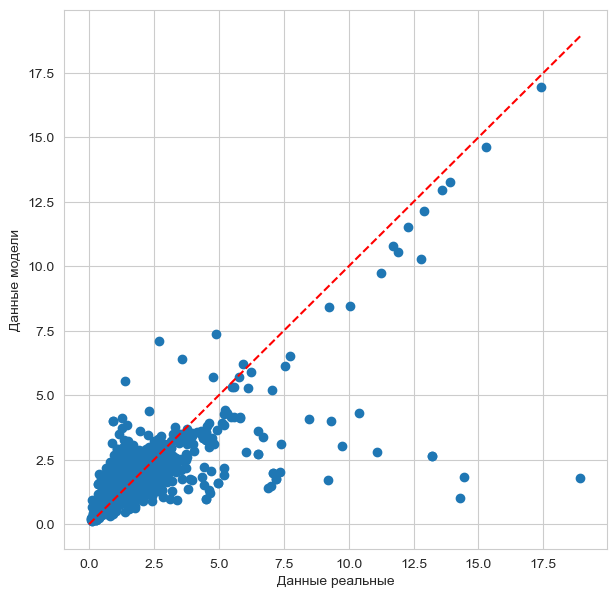

In [15]:
src.lib.model_score(model_1, X_test, y_test)

In [16]:
pred_cb_1 = model_1.predict(X_test)

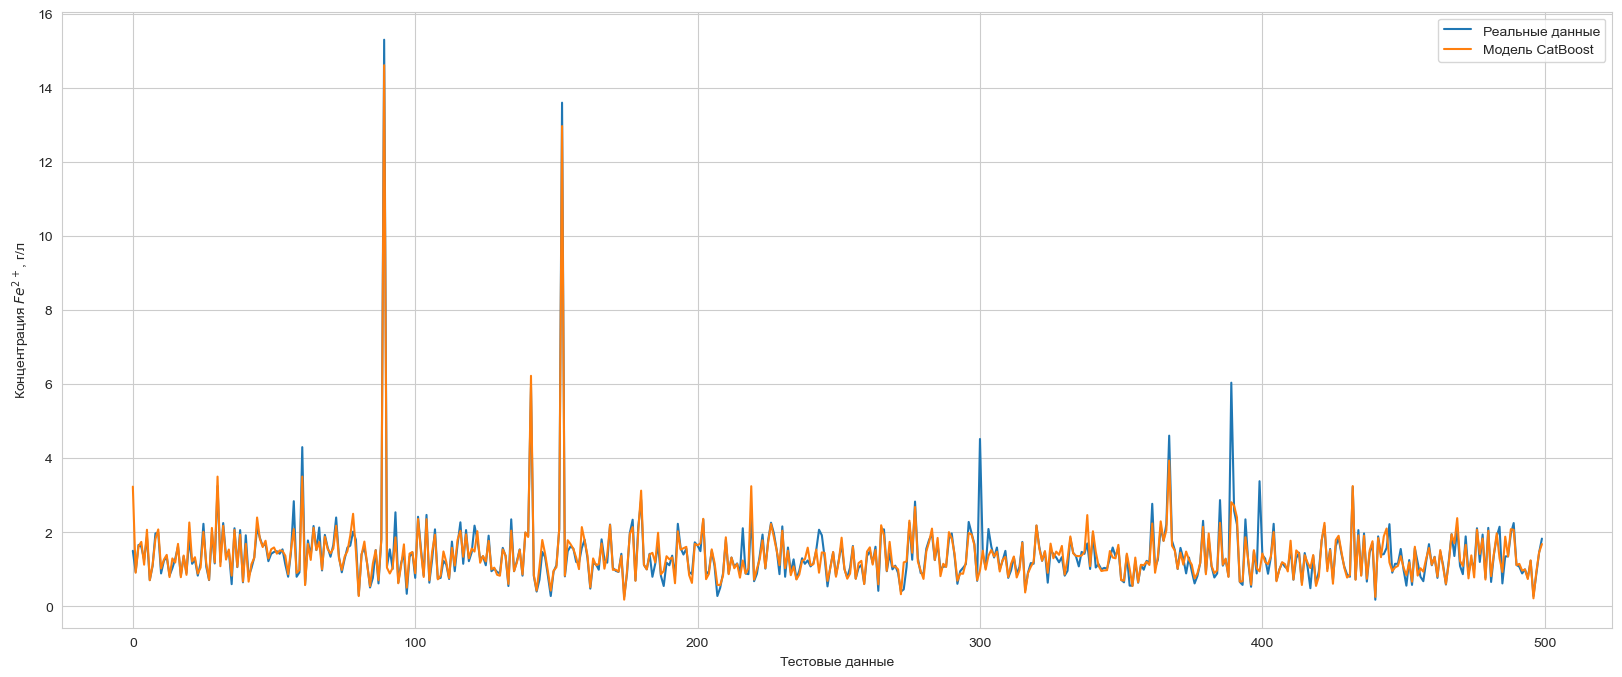

In [19]:
plt.figure(figsize=(20,8))

start = 2500
end = 3000

plt.plot(y_test.values[start:end], label='Реальные данные')
plt.plot(pred_cb_1[start:end], label='Модель CatBoost')

plt.ylabel("Концентрация $Fe^{2+}$, г/л")
plt.xlabel('Тестовые данные')

plt.legend()
plt.show();

## Посмотрим наиболее важные признаки

In [42]:
explainer = shap.Explainer(model_1)
shap_values = explainer(X_test)

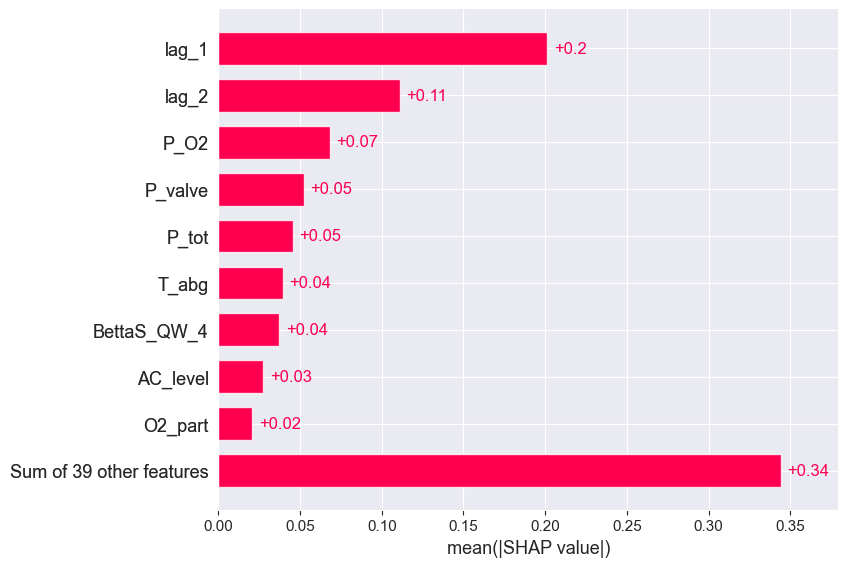

In [43]:
shap.plots.bar(shap_values)

После оптимизации модели, нужно будет проверить наиболее расходящиеся точки.

## Оптимизация параметров

In [27]:
model_1.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 1,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'random_seed': 0,
 'depth': 10,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.029999999329447743,
 'score_function': 

In [28]:
grid = {'learning_rate': [0.05, 0.2],
        'depth': [4, 10],
        'l2_leaf_reg': [1, 3, 5]}

cat = cb.CatBoostRegressor(loss_function='RMSE', train_dir='..\\cache')

grid_search_result = cat.grid_search(grid, X=X_train, y=y_train, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.6546056	test: 1.6135791	best: 1.6135791 (0)	total: 29ms	remaining: 28.9s
1:	learn: 1.5952312	test: 1.5523427	best: 1.5523427 (1)	total: 40.8ms	remaining: 20.4s
2:	learn: 1.5415298	test: 1.4958508	best: 1.4958508 (2)	total: 53ms	remaining: 17.6s
3:	learn: 1.4922194	test: 1.4438579	best: 1.4438579 (3)	total: 76.1ms	remaining: 19s
4:	learn: 1.4450963	test: 1.3937330	best: 1.3937330 (4)	total: 94.8ms	remaining: 18.9s
5:	learn: 1.4013534	test: 1.3470057	best: 1.3470057 (5)	total: 117ms	remaining: 19.3s
6:	learn: 1.3603797	test: 1.3041455	best: 1.3041455 (6)	total: 137ms	remaining: 19.4s
7:	learn: 1.3195429	test: 1.2630179	best: 1.2630179 (7)	total: 158ms	remaining: 19.6s
8:	learn: 1.2841265	test: 1.2260508	best: 1.2260508 (8)	total: 177ms	remaining: 19.5s
9:	learn: 1.2510710	test: 1.1904081	best: 1.1904081 (9)	total: 188ms	remaining: 18.6s
10:	learn: 1.2201062	test: 1.1565137	best: 1.1565137 (10)	total: 202ms	remaining: 18.2s
11:	learn: 1.1907182	test: 1.1255246	best: 1.1255246 

KeyboardInterrupt: 

In [ ]:
cat.get_all_params()

In [ ]:
cat.get_best_score()

In [ ]:
src.lib.model_score(cat, X_test, y_test)

Загрузка уже готовой модели

In [20]:
cat = cb.CatBoostRegressor()
cat.load_model('../models/model_2')

In [21]:
pred_cb_cat = cat.predict(X_test)

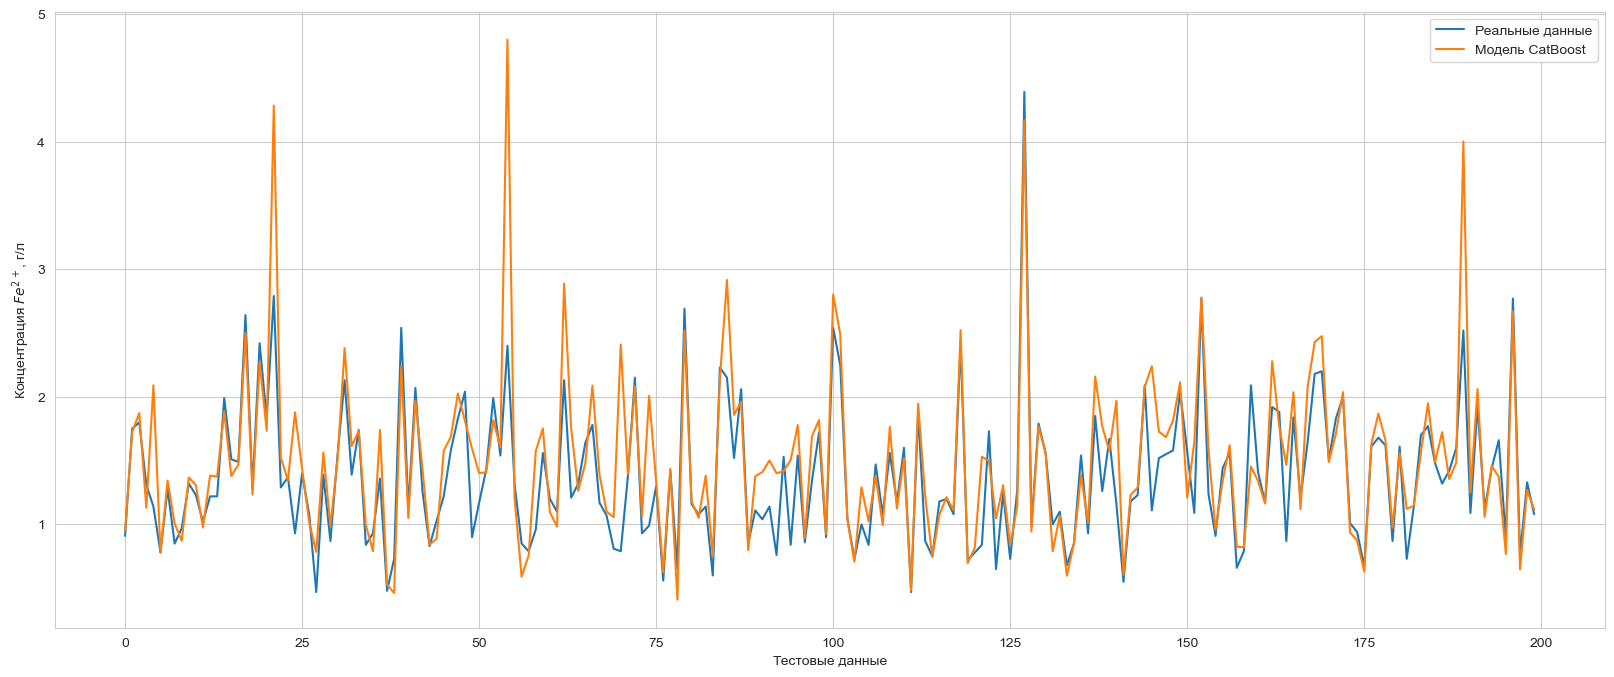

In [22]:
plt.figure(figsize=(20,8))

start = 1300
end = 1500

plt.plot(y_test.values[start:end], label='Реальные данные')
plt.plot(pred_cb_cat[start:end], label='Модель CatBoost')

plt.ylabel("Концентрация $Fe^{2+}$, г/л")
plt.xlabel('Тестовые данные')

plt.legend()
plt.show();

In [23]:
diff = y_test - pred_cb_cat
diff_base = y_test - pred_cb_1

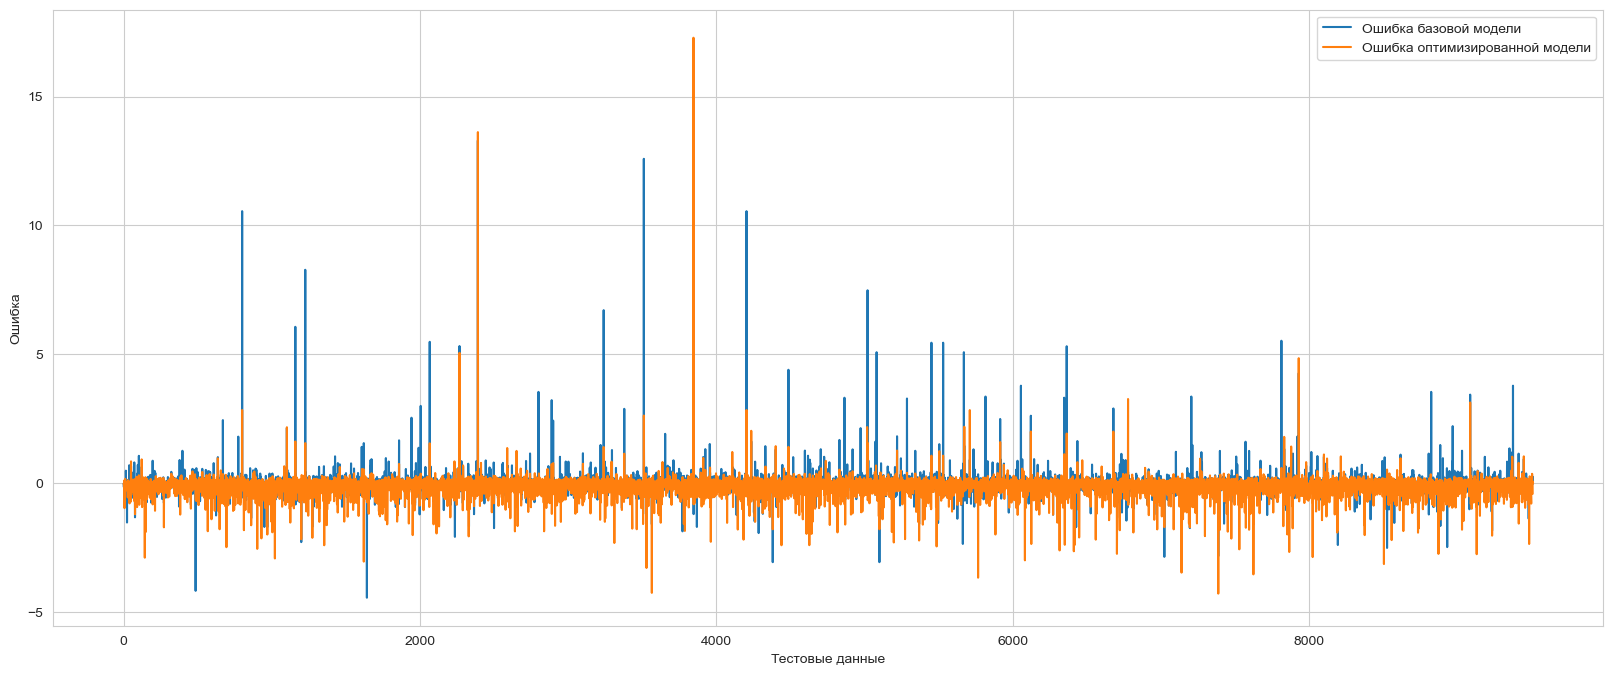

In [24]:
plt.figure(figsize=(20,8))

start = 0
end = 10000

plt.plot(diff_base.values[start:end], label='Ошибка базовой модели')
plt.plot(diff.values[start:end], label='Ошибка оптимизированной модели')

plt.ylabel("Ошибка")
plt.xlabel('Тестовые данные')

plt.legend()
plt.show();

## Сохранение полученной модели

In [57]:
cat.save_model('../models/model_2')

## Анализ влияния признаков на оптимизированной модели

In [172]:
explainer = shap.Explainer(cat)
shap_values = explainer(X_test)

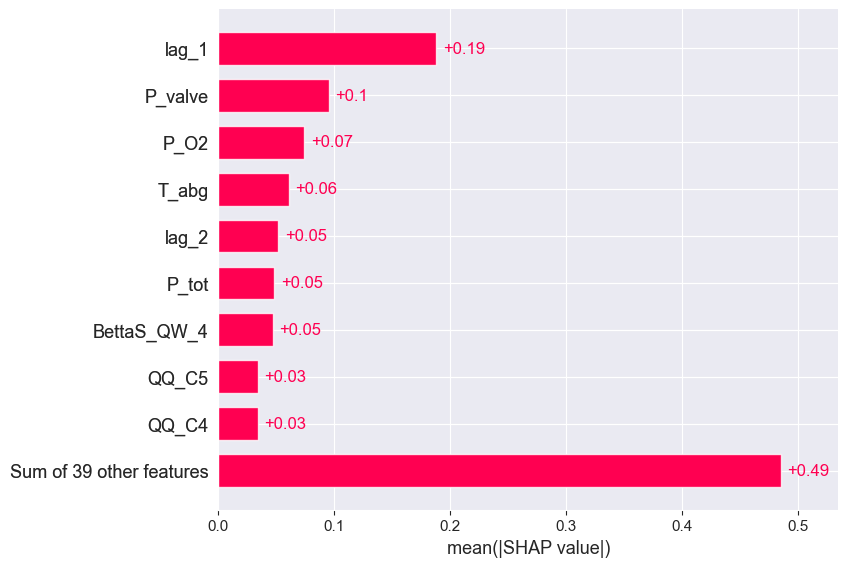

In [173]:
shap.plots.bar(shap_values)

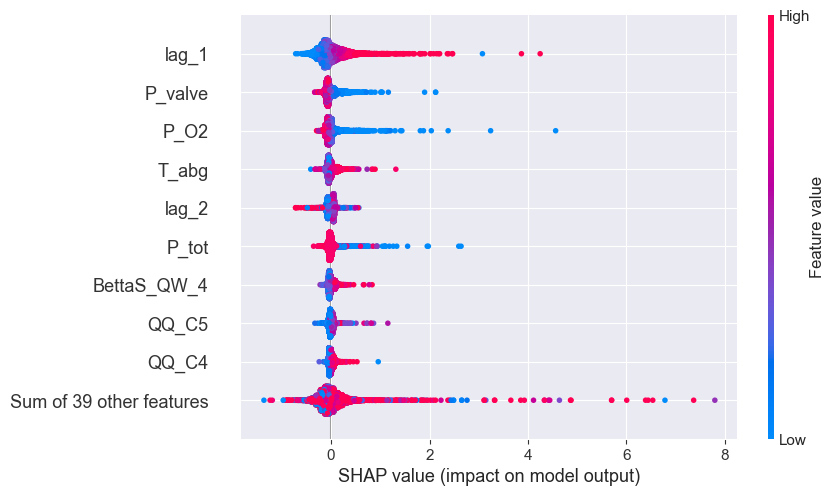

In [195]:
shap.plots.beeswarm(shap_values)

Посмотрим на точки, где модель сильно ошибается.

In [174]:
diff_df = pd.DataFrame(diff)
diff_df = diff_df.assign(real=y_test)
diff_df = diff_df.assign(pred=pred_cb_cat)
diff_df.reset_index(inplace=True)

diff_df.columns = ['Data', 'Diff', 'Real', 'Pred']

diff_df.head()

,Data,Diff,Real,Pred
0,2020-12-13 07:00:00,0.01,0.37,0.36
1,2021-06-25 01:00:00,-0.01,0.91,0.92
2,2020-02-26 12:00:00,-0.01,0.12,0.13
3,2021-07-28 14:00:00,-0.01,0.76,0.77
4,2020-04-27 05:00:00,0.02,1.02,1.00


In [196]:
diff_df.loc[diff_df['Diff'] > 1].sort_values(by=['Diff'], ascending=False)[:5]

,Data,Diff,Real,Pred
3846,2020-10-28 18:00:00,17.33,18.90,1.57
2391,2020-11-20 17:00:00,13.57,14.30,0.73
2267,2021-06-15 07:00:00,5.06,7.36,2.30
7931,2021-06-16 13:00:00,4.77,7.40,2.63
9088,2021-07-19 10:00:00,3.27,4.64,1.37


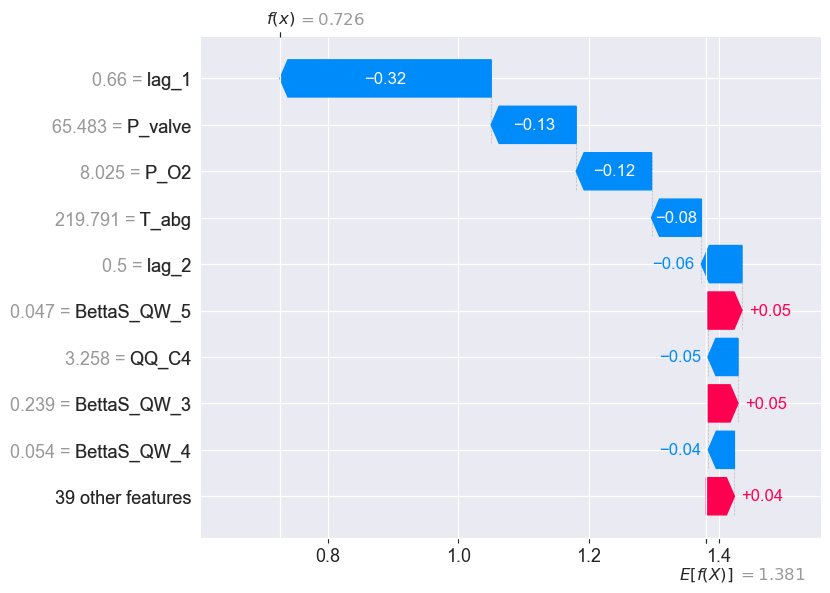

In [177]:
shap.plots.waterfall(shap_values[2391])

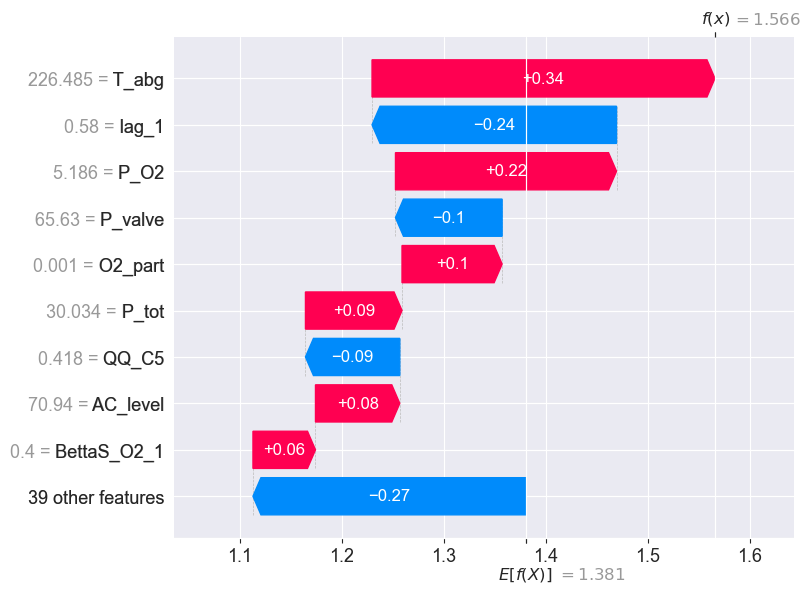

In [178]:
shap.plots.waterfall(shap_values[3846])

Посмотрим, что было во время таких больших значений концентрации железа.

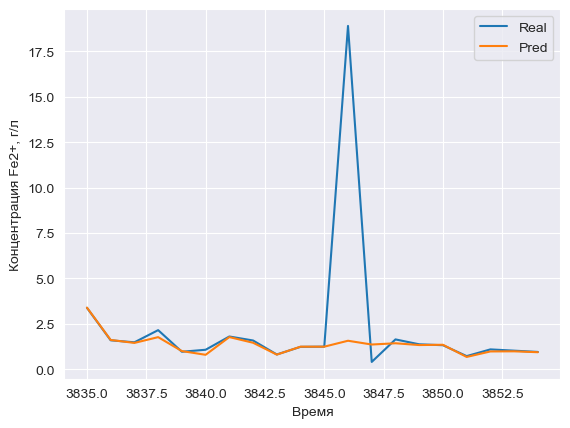

In [179]:
diff_df[['Real', 'Pred']].iloc[3835:3855].plot(xlabel = "Время", ylabel="Концентрация Fe2+, г/л");

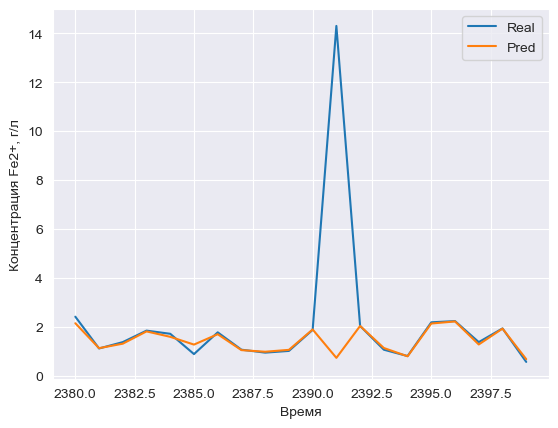

In [180]:
diff_df[['Real', 'Pred']].iloc[2380:2400].plot(xlabel = "Время", ylabel="Концентрация Fe2+, г/л");

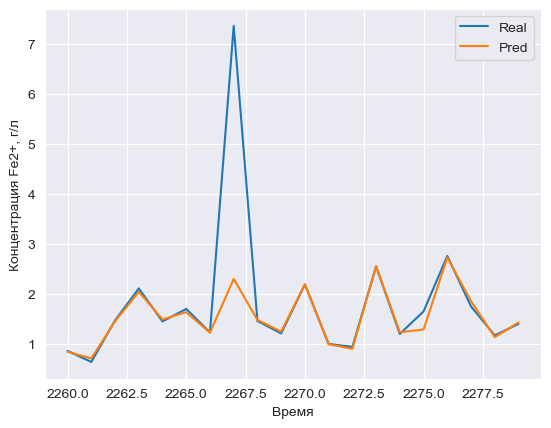

In [181]:
diff_df[['Real', 'Pred']].iloc[2260:2280].plot(xlabel = "Время", ylabel="Концентрация Fe2+, г/л");

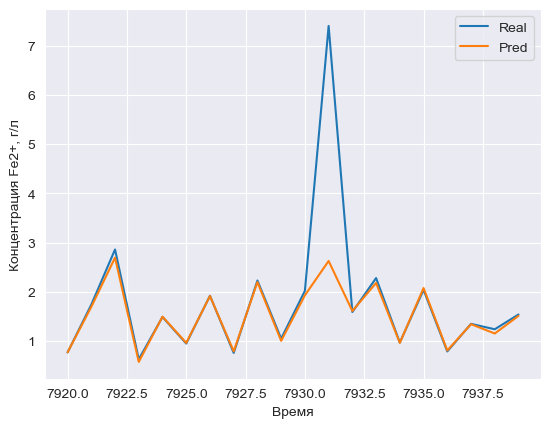

In [182]:
diff_df[['Real', 'Pred']].iloc[7920:7940].plot(xlabel = "Время", ylabel="Концентрация Fe2+, г/л");

Анализ точек с максимальной ошибкой показывает, что на самом деле это не ошибка модели, а скорее всего это ошибки и выбросы в экспериментальных данных.

In [198]:
diff_df.loc[(diff_df['Real'] > 10) & (diff_df['Diff'] < 1)].sort_values(by=['Real'], ascending=False)[:10]

,Data,Diff,Real,Pred
6779,2021-03-30 12:00:00,0.00,17.40,17.40
2589,2020-06-01 12:00:00,0.00,15.30,15.30
3511,2019-09-20 00:00:00,0.00,14.43,14.43
3256,2021-04-12 03:00:00,0.00,13.90,13.90
2652,2021-08-08 14:00:00,0.01,13.60,13.59
800,2021-04-07 08:00:00,-0.00,13.20,13.20
4204,2021-04-07 08:00:00,-0.00,13.20,13.20
6724,2021-07-27 08:00:00,0.00,12.90,12.90
5916,2020-02-03 13:00:00,0.02,12.78,12.76
5899,2021-04-08 21:00:00,0.00,12.30,12.30


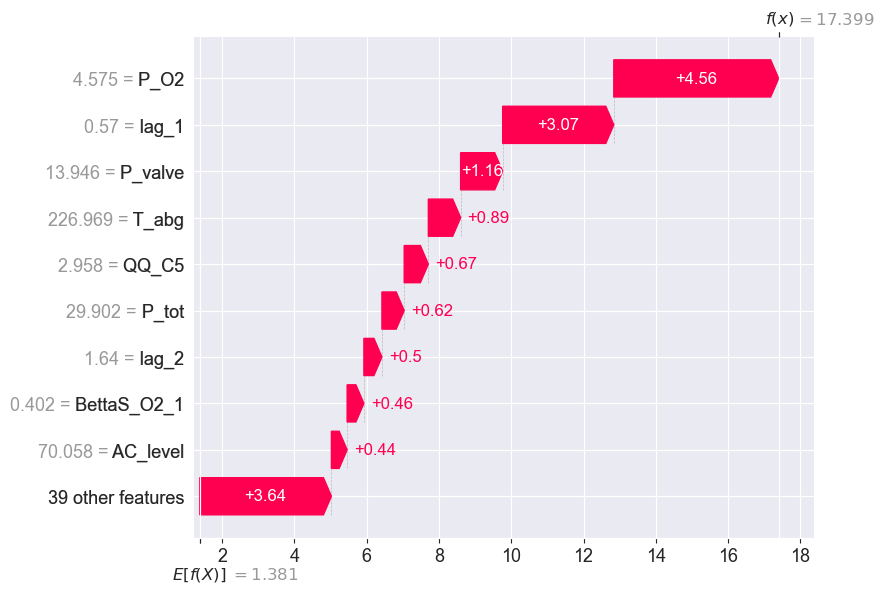

In [184]:
shap.plots.waterfall(shap_values[6779])

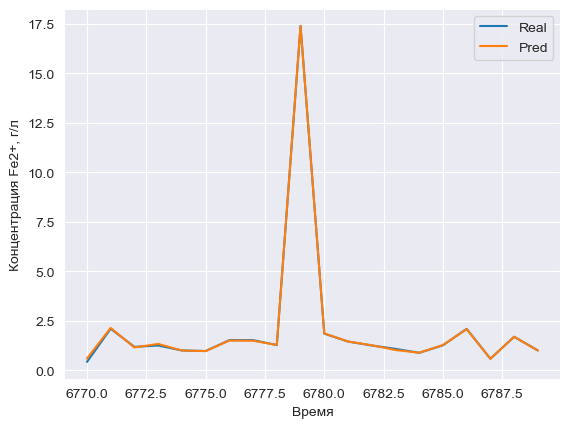

In [185]:
diff_df[['Real', 'Pred']].iloc[6770:6790].plot(xlabel = "Время", ylabel="Концентрация Fe2+, г/л");

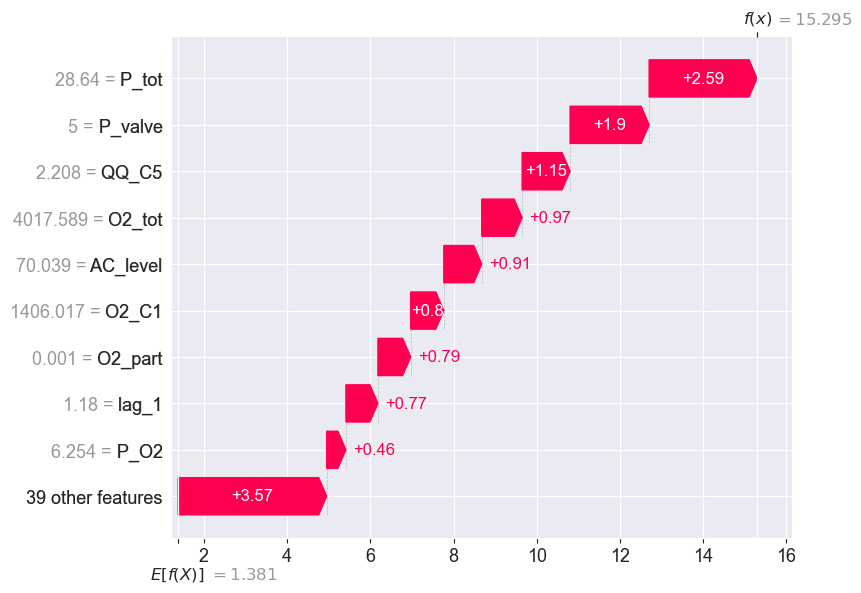

In [199]:
shap.plots.waterfall(shap_values[2589])

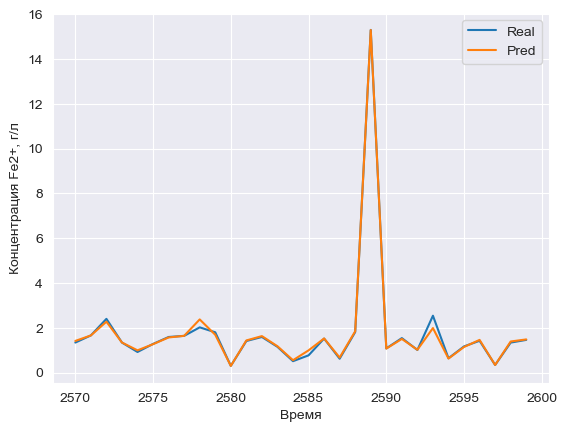

In [200]:
diff_df[['Real', 'Pred']].iloc[2570:2600].plot(xlabel = "Время", ylabel="Концентрация Fe2+, г/л");